In [20]:
import math
import typing as T

import numpy as np
from numpy import linalg
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import utils


##### **Defining robots states**



In [5]:
class State:
    def __init__(self, x: float, y: float, V: float, th: float) -> None:
        self.x = x
        self.y = y
        self.V = V
        self.th = th

    # By using the @property decorator, we turn them into "getter" methods, 
    # which means we can access them without calling them as functions but 
    # rather like attributes.

    @property
    def xd(self) -> float:
        return self.V*np.cos(self.th)
    
    @property
    def yd(self) -> float:
        return self.V*np.sin(self.th)
    

##### **Calculating coefficients of the polynomial time trajectory**



In [6]:
def traj_coeff(initial_state: State, final_state: State, tf: float) -> np.ndarray:

    ti = 0
    x_boundary = [initial_state.x, initial_state.xd, final_state.x, final_state.xd]
    y_boundary = [initial_state.y, initial_state.yd, final_state.y, final_state.yd]

    # polynimial basis function 
    basis_funcs = np.array([[1, ti, ti**2, ti**3],
                            [0, 1, 2*ti, 3*ti**2],
                            [1, tf, tf**2, tf**3],
                            [0, 1, 2*tf, 3*tf**2]])


    # calculate coefficients for x(t) and y(t) using differential flatness and boundary conditions
    x_coeff = np.linalg.solve(basis_funcs, x_boundary)
    y_coeff = np.linalg.solve(basis_funcs, y_boundary)

    return x_coeff, y_coeff

To compute the state trajectory $[x, y, \theta, \dot{x}, \dot{y}, \ddot{x}, \ddot{y}]$ from $t = 0$ to $t = \text{tf}$, we will use the polynomial coefficients obtained from the `traj_coeff` function. The coefficients are calculated for the positions $x(t)$ and $y(t)$ using the fourth-order polynomials.

##### **Calculating trajectory using coefficients and time horizon**



In [7]:
def traj_compute(coeff_z1: np.ndarray, coeff_z2: np.ndarray, tf: float, N: int) -> T.Tuple[np.ndarray, np.ndarray]:
    
    time_span = np.linspace(0, tf, N) #generate evenly spaced time points from 0 to final time tf
    traj = np.zeros((N, 7)) # 7 is the number of the states of the robot

    for i in range(N):
        t = time_span[i]
        z1 = coeff_z1[0]*1 + coeff_z1[1]*t + coeff_z1[2]*t**2 + coeff_z1[3]*t**3
        z2 = coeff_z2[0]*1 + coeff_z2[1]*t + coeff_z2[2]*t**2 + coeff_z2[3]*t**3

        z1_dot = coeff_z1[0]*0 + coeff_z1[1]*1 + 2*coeff_z1[2]*t + 3*coeff_z1[3]*t**2
        z2_dot = coeff_z2[0]*0 + coeff_z2[1]*1 + 2*coeff_z2[2]*t + 3*coeff_z2[3]*t**2

        z1_ddot = coeff_z1[0]*0 + coeff_z1[1]*0 + 2*coeff_z1[2] + 6*coeff_z1[3]*t
        z2_ddot = coeff_z2[0]*0 + coeff_z2[1]*0 + 2*coeff_z2[2] + 6*coeff_z2[3]*t
        
        traj[i, 0] = z1
        traj[i, 1] = z2
        traj[i, 2] = z1_dot
        traj[i, 3] = z2_dot
        traj[i, 4] = z1_ddot
        traj[i, 5] = z2_ddot
        traj[i, 6] = np.arctan(z2_dot/(z1_dot+1e-6))


    return time_span, traj

In [8]:
def compute_controls(traj: np.ndarray) -> T.Tuple[np.ndarray, np.ndarray]:

    N = traj.shape[0]
    V = np.zeros((N))
    omega = np.zeros((N))

    for i in range(N):
        V[i] = np.sqrt(traj[i, 2]**2 + traj[i, 3]**2)
        omega[i] = (traj[i, 5]*traj[i, 2] - traj[i, 4]*traj[i, 3]) / (traj[i, 2]**2 + traj[i, 3]**2)

    return V, omega

In [9]:
def compute_arc_length(V: np.ndarray, t: np.ndarray) -> np.ndarray:
    s = (cumtrapz(V, t))
    s = np.insert(s, 0, 0)
    return s

In [10]:
def rescale_control(V: np.ndarray, omega: np.ndarray, V_max: float, omega_max: float) -> np.ndarray:
 
    omega_constrained = np.zeros_like(omega)


    V_tilde = np.minimum(V, V_max)

    for i in range(len(omega)):
        if omega[i]>=0:
            omega_constrained[i] = np.minimum(omega[i], omega_max)
        else:
            omega_constrained[i] = -np.minimum(abs(omega[i]), omega_max)


    V_s = (omega_constrained*V)/(omega+1e-6)
    
    V_tilde = np.minimum(V_tilde, V_s)


    omega_tilde = (omega/V)*V_tilde
    
    return V_tilde, omega_tilde

In [11]:
def rescale_time(V_tilde: np.ndarray, s: np.ndarray) -> np.ndarray:
    tau = cumtrapz(1/V_tilde, s)
    tau = np.insert(tau, 0, 0)
    return tau

In [12]:
def interpolate_traj(
    traj: np.ndarray,
    tau: np.ndarray,
    V_tilde: np.ndarray,
    om_tilde: np.ndarray,
    dt: float,
    s_f: State
) -> T.Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    # Get new final time
    tf_new = tau[-1]

    # Generate new uniform time grid
    N_new = int(tf_new/dt)
    t_new = dt*np.array(range(N_new+1))

    # # Interpolate for state trajectory
    traj_scaled = np.zeros((N_new+1,7))
    traj_scaled[:,0] = np.interp(t_new,tau,traj[:,0])   # x
    traj_scaled[:,1] = np.interp(t_new,tau,traj[:,1])   # y
    traj_scaled[:,2] = np.interp(t_new,tau,traj[:,2])   # th

    # Interpolate for scaled velocities
    V_scaled = np.interp(t_new, tau, V_tilde)           # V
    om_scaled = np.interp(t_new, tau, om_tilde)         # om

    # Compute xy velocities
    traj_scaled[:,3] = V_scaled*np.cos(traj_scaled[:,2])    # xd
    traj_scaled[:,4] = V_scaled*np.sin(traj_scaled[:,2])    # yd

    # Compute xy acclerations
    traj_scaled[:,5] = np.append(np.diff(traj_scaled[:,3])/dt,-s_f.V*om_scaled[-1]*np.sin(s_f.th)) # xdd
    traj_scaled[:,6] = np.append(np.diff(traj_scaled[:,4])/dt, s_f.V*om_scaled[-1]*np.cos(s_f.th)) # ydd

    return t_new , V_scaled, om_scaled, traj_scaled


In [ ]:

dt = 0.001
N = 40
tf = 15
V_max = 0.5
omega_max  = 1
initial_state = State(0, 0, 0.5, -np.pi/2)
final_state = State(5, 5, 0.5, -np.pi/2)

coeff_x, coeff_y = traj_coeff(initial_state, final_state, tf)
t, trajectory = traj_compute(coeff_x, coeff_y, tf, N)
V, omega = compute_controls(trajectory)
s = compute_arc_length(V, t)
V_scaled, omega_scaled = rescale_control(V, omega, V_max, omega_max)
tau = rescale_time(V_scaled, s)
# tf_new = tau[-1, 0]

# N_new = int(tf_new/dt)

t_new,V_scaled, om_scaled, traj_scaled  = interpolate_traj(trajectory, tau, V_scaled, omega_scaled, dt, final_state)
data = {'z': traj_scaled, 'V': V_scaled, 'om': om_scaled}
save_dict(data, "data/differential_flatness.pkl")
maybe_makedirs('plots')

# plt.plot( t_new, traj_scaled[:,0])
# plt.show()
# plt.plot( t, trajectory[:,0])
# plt.show()
# # plt.plot(V_scaled)
# plt.plot(omega_scaled)

In [27]:
def plot_results(traj, s_0, s_f, t, V, om, part_b_complete, t_new, V_scaled, om_scaled, tau, s ):

    plt.figure(figsize=(15, 7))
    plt.subplot(2, 2, 1)
    plt.plot(traj_scaled[:,0], traj_scaled[:,1], 'k-',linewidth=4)
    plt.plot(traj[:,0], traj[:,1], 'r-',linewidth=1)

    plt.grid(True)
    plt.plot(s_0.x, s_0.y, 'go', markerfacecolor='green', markersize=15)
    plt.plot(s_f.x, s_f.y, 'ro', markerfacecolor='red', markersize=15)
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title("Path (position)")
    plt.axis([-1, 6, -1, 6])

    # plt.figure(figsize=(15, 7))
    # plt.subplot(2, 2, 1)
    # plt.plot(traj[:,0], traj[:,1], 'k-',linewidth=2)
    # plt.grid(True)
    # plt.plot(s_0.x, s_0.y, 'go', markerfacecolor='green', markersize=15)
    # plt.plot(s_f.x, s_f.y, 'ro', markerfacecolor='red', markersize=15)
    # plt.xlabel('X [m]')
    # plt.ylabel('Y [m]')
    # plt.title("Path (position)")
    # plt.axis([-1, 6, -1, 6])

    ax = plt.subplot(2, 2, 2)
    plt.plot(t, V, linewidth=2)
    plt.plot(t, om, linewidth=2)
    plt.grid(True)
    plt.xlabel('Time [s]')
    plt.legend(['V [m/s]', '$\omega$ [rad/s]'], loc="best")
    plt.title('Original Control Input')
    plt.tight_layout()

    plt.subplot(2, 2, 4, sharex=ax)
    if part_b_complete:
        plt.plot(t_new, V_scaled, linewidth=2)
        plt.plot(t_new, om_scaled, linewidth=2)
        plt.legend(['V [m/s]', '$\omega$ [rad/s]'], loc="best")
        plt.grid(True)
    else:
        plt.text(0.5,0.5,"[Problem iv not completed]", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xlabel('Time [s]')
    plt.title('Scaled Control Input')
    plt.tight_layout()

    plt.subplot(2, 2, 3)
    if part_b_complete:
        h, = plt.plot(t, s, 'b-', linewidth=2)
        handles = [h]
        labels = ["Original"]
        h, = plt.plot(tau, s, 'r-', linewidth=2)
        handles.append(h)
        labels.append("Scaled")
        plt.legend(handles, labels, loc="best")
    else:
        plt.text(0.5,0.5,"[Problem iv not completed]", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.grid(True)
    plt.xlabel('Time [s]')
    plt.ylabel('Arc-length [m]')
    plt.title('Original and scaled arc-length')
    plt.tight_layout()
    # plt.savefig("plots/differential_flatness.png")
    plt.show()

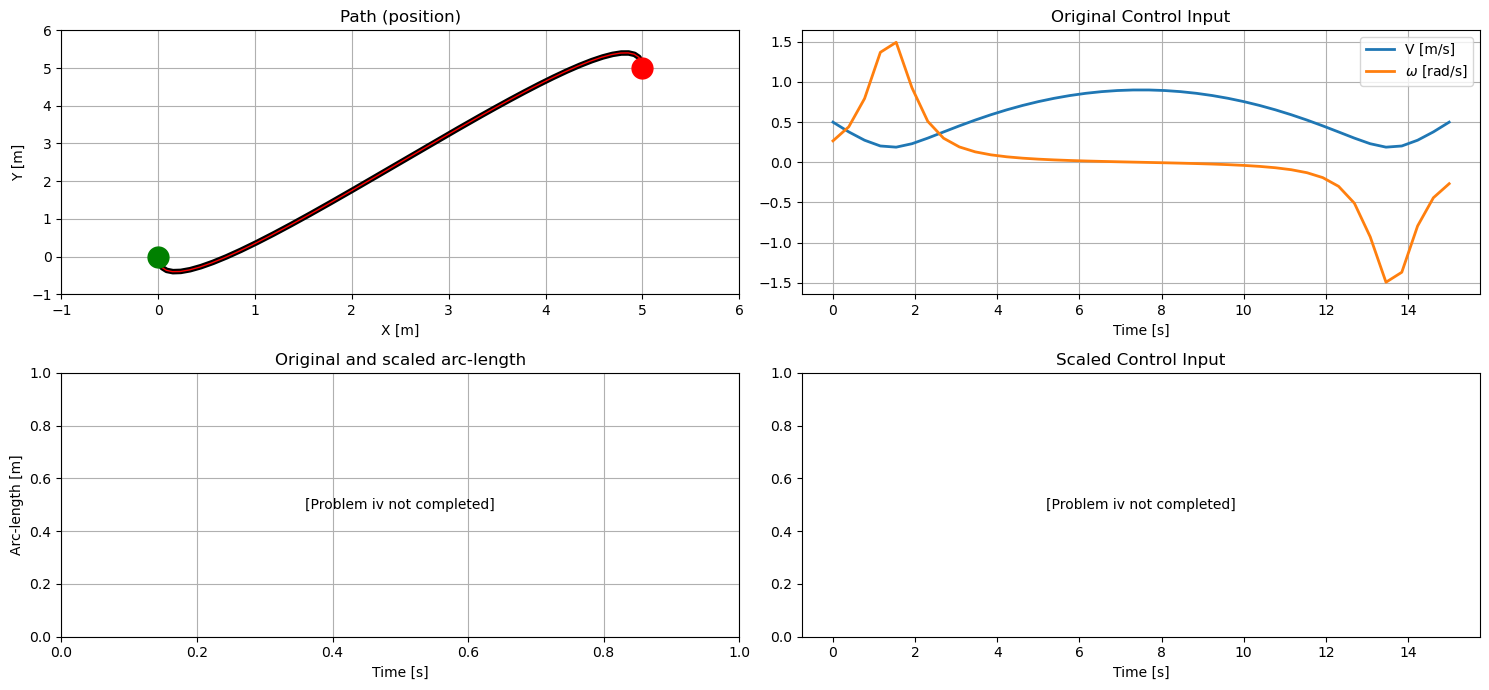

In [28]:
part_b_complete=False
plot_results(trajectory, initial_state, final_state, t, V, omega, part_b_complete, t_new, V_scaled, om_scaled, tau, s )